#### Using Dow Jones century data until December 2018

https://stooq.com/q/?s=%5edji - more historical data since 1896 

https://finance.yahoo.com/quote/%5EDJI/history?period1=475815600&period2=1545271200&interval=1d&filter=history&frequency=1d - less historical data since 1985 but more clean

#### Create my Candle Pattern predictor for next day movement.

In [2]:
%matplotlib inline

In [3]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [4]:
cd ..

/home/andre/Projects/stocks


In [5]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import prepareData, meta5Ibov
from algos.nn import torchNN, torchCV, torchUtil
import torch as th
import scipy

### Load Dow Jones 1 Century Data

In [6]:
cd data

/home/andre/Projects/stocks/data


In [7]:
pwd

'/home/andre/Projects/stocks/data'

### Devido ao desdobramento de ações, divisão de ações melhor usar o Ibovespa

In [8]:
# dow = pd.read_csv('WIN@_H2_2013_2018.csv', delimiter='\t',
#                  na_values=['null', '0'], 
#                 names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Volume', 'Spread'],
#                 header=0)

dow = pd.read_csv('dow_jones_1985_2018_daily.csv', delimiter=',',
                 na_values=['null', '0'])

In [9]:
dow.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8573,2019-02-04,25062.119141,25239.910156,24977.669922,25239.369141,25239.369141,298540000
8574,2019-02-05,25287.929688,25427.320313,25287.650391,25411.519531,25411.519531,310650000
8575,2019-02-06,25371.570313,25439.039063,25312.060547,25390.300781,25390.300781,247590000
8576,2019-02-07,25265.810547,25314.259766,25000.519531,25169.529297,25169.529297,295460000
8577,2019-02-08,25042.359375,25106.390625,24883.039063,25106.330078,25106.330078,248210000


In [10]:
#for yahooo finance data
dow['Close'] = dow['Adj Close']  
dow.drop(['Adj Close'] , axis=1, inplace=True) # Close is better than Adjusted Close
# # 1/3%

In [11]:
dow.isnull().sum().sum() # total number of cells with nans 

0

In [12]:
dow.dropna(inplace=True)

Convert to datetime Date

In [13]:
dow.Date = pd.to_datetime(dow.Date)

In [14]:
dow.set_index(dow.Date, drop=True, inplace=True);

In [15]:
dow.index = dow.index.date # remove useless time part of index

In [16]:
dow.drop(['Date'], axis=1, inplace=True)

In [17]:
dow.head(2)

,Open,High,Low,Close,Volume
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,16820000


### **Let's create the up/down class for each day compared with the previous**

In [18]:
dow['updown'] = np.nan

In [19]:
dow.head(2)

,Open,High,Low,Close,Volume,updown
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,13560000,NaN
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,16820000,NaN


We are pushing the days were there were no movement to the down. 

In [20]:
dow.Close.values[1:] > dow.Close.values[:-1] 

array([False, False, False, ..., False, False, False])

In [21]:
# candles on close
dow.updown.values[1:] = dow.Close.values[1:] > dow.Close.values[:-1] 
dow.updown = dow.updown.map(lambda x: 1 if x else 0)

In [22]:
dow.updown.values[0] = -1 # first day has no info

In [23]:
dow.head()

,Open,High,Low,Close,Volume,updown
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,13560000,-1
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,16820000,0
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,14070000,0
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,10980000,0
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,11630000,1


In [24]:
dow.tail()

,Open,High,Low,Close,Volume,updown
2019-02-04,25062.119141,25239.910156,24977.669922,25239.369141,298540000,1
2019-02-05,25287.929688,25427.320313,25287.650391,25411.519531,310650000,1
2019-02-06,25371.570313,25439.039063,25312.060547,25390.300781,247590000,0
2019-02-07,25265.810547,25314.259766,25000.519531,25169.529297,295460000,0
2019-02-08,25042.359375,25106.390625,24883.039063,25106.330078,248210000,0


In [25]:
#dow.Close.resample('D') # maybe use this someday

### Lets take a look on that data

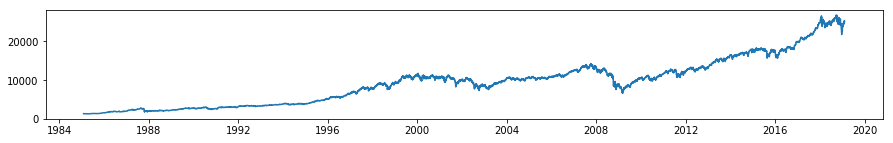

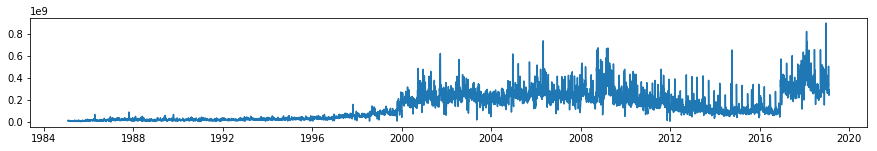

In [26]:
plt.figure(figsize=(15,2))
plt.plot(dow.Close) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.Volume) # dow.index.map(lambda x: x.year)

In [27]:
dow.Volume.head()

1985-01-29    13560000
1985-01-30    16820000
1985-01-31    14070000
1985-02-01    10980000
1985-02-04    11630000
Name: Volume, dtype: int64

#### Since the data is `exponentially` increasing lets see if we can detrend it.
Lets first use a simple log function

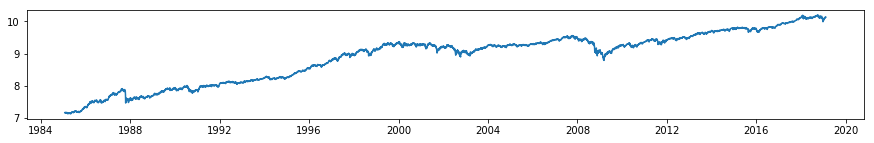

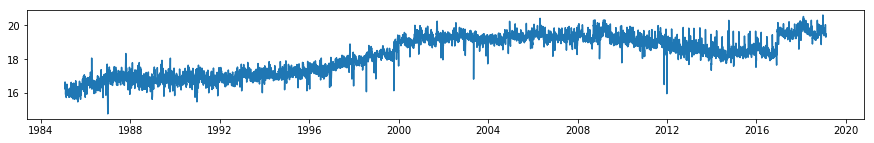

In [28]:
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.Close)) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.Volume)) # dow.index.map(lambda x: x.year)

In [29]:
for column in dow.columns[:-1]: # all less the up/down class
    dow.loc[:, column] = np.log(dow.loc[:, column].values)

For simplicity a linear detrend to solve the rest.  First try did not pose nice results.  
Use it just for viewing. 

But since we are trying to analyse a specific time-scale 5/6 days all other variations are noise to us. So let's try to remove a moving average of three weeks (3*5=15 days). Need to figure out a better.  

In [30]:
from scipy.signal import detrend
dowv = dow.copy()
dowv.iloc[:,:5] =  detrend(dowv.values[:,:5], axis=0)

Text(0.5, 1.0, 'Just for viewing data')

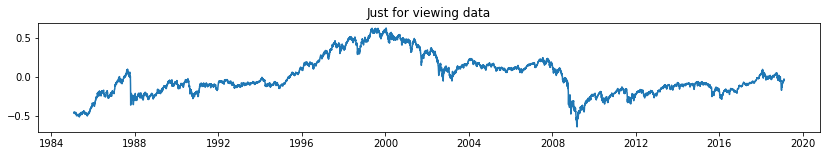

In [31]:
plt.figure(figsize=(14,2))
plt.plot(dowv.Close)
plt.title('Just for viewing data')

In [32]:
import talib as ta

In [33]:
# this will need to change to a EMA or SMA due future data dependence
for col in range(5):
    #trend = np.convolve(dow.iloc[:, col], np.ones((15,))/15, mode='valid') 
    trend = ta.SMA(dow.iloc[:, col].values.astype(np.double), 2)
    #dow.iloc[7:-7, col] -= trend # to fit at the center -7 + 7 samples are border
    dow.iloc[:, col] -= trend # to fit at the center -7 + 7 samples are border
# dow.drop(dow.index[:7], inplace=True) # due border effect
# dow.drop(dow.index[-7:], inplace=True)
dow.dropna(inplace=True) # drop first nan value

In [34]:
dowv = dowv.loc[dow.index] # update the viewing 

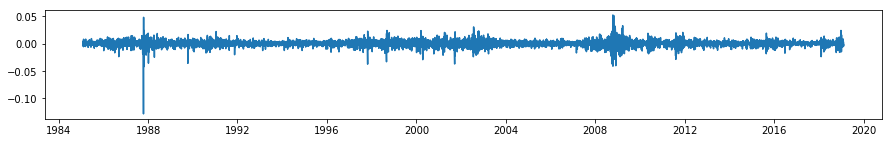

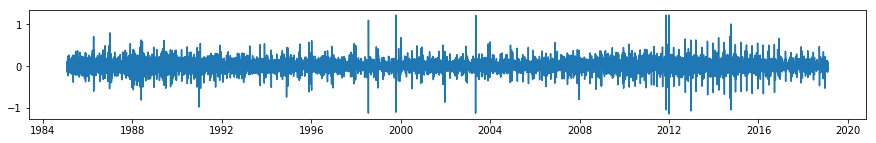

In [35]:
plt.figure(figsize=(15,2))
plt.plot(dow.Close) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.Volume) # dow.index.map(lambda x: x.year)

For while, let inflation be!   
Will just calculate pattern of candles.   

In [36]:
prices = np.random.rand(50)
prices = ta.SMA(prices, 3)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


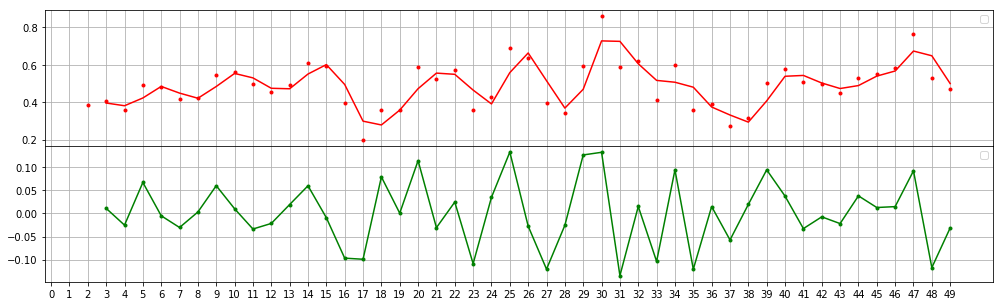

In [37]:
f, axr = plt.subplots(2, sharex=True, figsize=(17,5))
f.subplots_adjust(hspace=0)
axr[0].plot(prices, '.r')
axr[0].plot(ta.SMA(prices,2), '-r')
axr[0].set_xticks(np.arange(0, 50))
axr[0].grid(which='both')
axr[0].legend()
axr[1].plot(prices-ta.SMA(prices, 2), '.g')
axr[1].plot(prices-ta.SMA(prices, 2), '-g')
axr[1].grid()
axr[1].legend()

### **Let's create the another class based  on the difference to the SMA**

1. The difference to the SMA of today is BIGGER than the previous day 1
0. The difference to the SMA of today is SMALLER than the previous day 0


    | SMA  | Close |  diff  |
    |------|-------|--------|
    |  -   |   8   |    -   |
    | 7.5  |   7   |  -0.5  |
    | 5.5  |   4   |  -0.5  |   -> diff = diff[-1] -> 0 # decresing at same speed
    | 3.0  |   2   |  -1.0  |   -> diff < diff[-1] -> 0
    | 2.5  |   3   |   0.5  |   -> diff > diff[-1] -> 1
    | 3.5  |   4   |   0.5  |   -> diff = diff[-1] -> 0 # increasing at same speed 
    | 5.0  |   6   |   1.0  |   -> diff > diff[-1] -> 1 # increasing faster
    | 6.0  |   6   |   0.0  |   -> diff < diff[-1] -> 0 # nothing happened
    
    
### Somehow this trains much faster and easier

this favors classification of UP movements that are more trustworthy

to favor classification of DOWN movements should reverse the class

- **If it was going up on the prevous SMA 2 days and the residuous prediction is for going up. Certainly it will only go up!**
- **If it was going down on the previous SMA 2 days and the residous prediction is for decreasing. Certainly it will go down!**

In [38]:
dow['sup'] = np.nan

We are pushing the days were there were no movement to the down. 

In [39]:
# candles on close
dow.sup.iloc[1:] = dow.Close.values[1:] > dow.Close.values[:-1] 
dow.sup.values[:] = dow.sup.map(lambda x: 1 if x else 0)

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
dow.sup.values[0] = 0 # first day has no info - but lets not contaminated the mean

In [41]:
dowv['sup'] = dow.sup.copy()

### Lets Standardize data before creating the training Vector or Feature Vector X

From the histograms we can see there is no class in-balance at first look. 

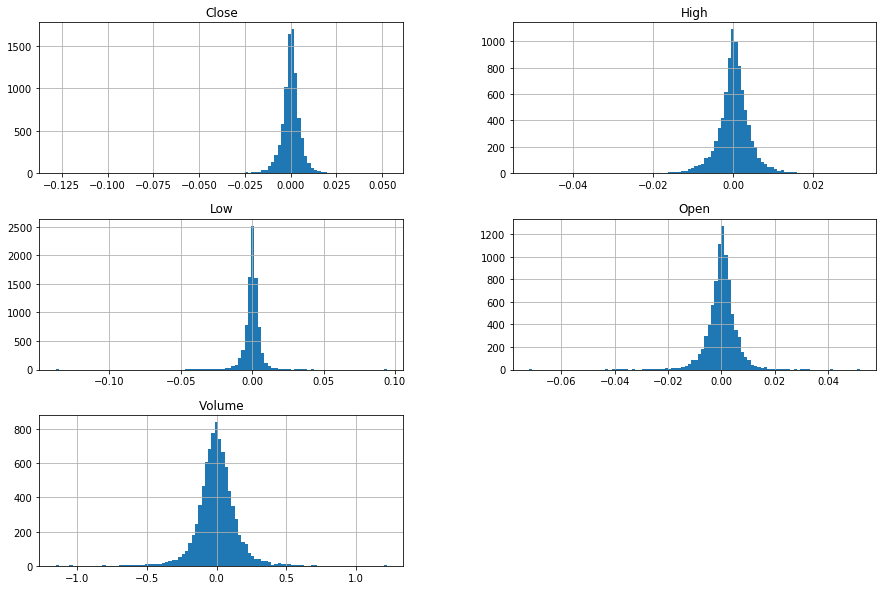

In [42]:
dow.iloc[:, :5].hist(bins=100, figsize=(15,10));

In [43]:
dow.head(1)

,Open,High,Low,Close,Volume,updown,sup
1985-01-30,0.007631,0.003695,0.004729,-0.001837,0.107722,0,0


In [44]:
newcolumns=dow.columns[:-2].tolist()
newcolumns.extend(['sup', 'updown'])
dow = dow.reindex(columns=newcolumns)
dowv = dowv.reindex(columns=newcolumns)

In [45]:
dow.head(1)

,Open,High,Low,Close,Volume,sup,updown
1985-01-30,0.007631,0.003695,0.004729,-0.001837,0.107722,0,0


In [46]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [47]:
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)

X_trans = quantile_transformer.fit_transform(dow.values[:,:-2])

In [48]:
X_trans.shape

(8577, 5)

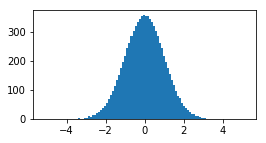

In [49]:
plt.figure(figsize=(4,2))
plt.hist(X_trans[:,4], bins=100);

In [50]:
np.mean(X_trans[:,4]), np.std(X_trans[:,4])

(0.00010038168269586452, 1.0037408525824172)

In [51]:
X_trans.shape

(8577, 5)

In [52]:
#X = np.zeros((X_trans.shape[0], 5))
X = np.array(X_trans)
#X[:, 5] = dow.values[:,-2]
#X[:, 5] = (X[:, 5] - X[:, 5].mean())/X[:, 5].std() # normalize variance=1 mean=0

In [53]:
np.mean(X, axis=0)

array([ 1.97628532e-04,  1.28896014e-04, -3.35729885e-05,  1.67641834e-04,
        1.00381683e-04])

In [54]:
np.std(X, axis=0)

array([1.00108639, 1.00096912, 1.00064504, 1.00093068, 1.00374085])

### Lets make the feature vector X


We will shift forward 5 days so we can use the last ones to predict the next.  
So we can use previous days information to train to predict next one.  

We will train like this:

[-5, -4, -3, -2, -1] -> [0]  
[-4, -3, -2, -1,  0] -> [1]  
[-3, -2, -1,  0,  1] -> [2]  
        ...              
 
but each day O, H, L, C, V will be a row so:

[-5, -4, -3, -2, -1] -> [0]
is  

[O[-5], H[-5], L[-5], C[-5], V[-5], O[-4], H[-4], L[-4], C[-4], V[-4] ... O[-1], H[-1], L[-1], C[-1], V[-1]] -> [0]

Meaning training or feature vector will have 5*5 = 25 dimension. 

In [55]:
data = X # we don't use the training class

In [56]:
pdays=22 # previous hours ~ 5 days on H2 time-frame

[1, 3, 4, 5, 6, 3]

[1, 3, 4]  
[3, 4, 5]  
[4, 5, 6]  
[5, 6, 3]  

In [57]:
data.shape

(8577, 5)

In [58]:
X = np.zeros((len(X)-pdays+1, pdays*5))
# maybe using np.tile with np.repeat is faster but dont know how
for i in range(len(X)-pdays+1):
    X[i,:] = data[i:i+pdays].flatten()

In [59]:
len(X)

8556

### Lets make the class vector or target vector Y

In [60]:
dow.head(3)

,Open,High,Low,Close,Volume,sup,updown
1985-01-30,0.007631,0.003695,0.004729,-0.001837,0.107722,0,0
1985-01-31,-0.005476,-0.004503,-0.002465,-0.000431,-0.089262,1,0
1985-02-01,-0.002461,-0.002826,-0.001129,-0.003529,-0.123985,0,0


In [61]:
dow.sup = dow.sup.values.astype(int)

In [62]:
dow = dow[pdays:] # the first days dont have class for training so we dont need them
dowv = dowv[pdays:] # same for plotting
Y = dow.sup #dow.updown
Y = Y.values

In [63]:
Xfuture = X[-1] # last day/hour is prediction of future
X = X[:-1] # this is training data

In [64]:
dowv.head(3)

,Open,High,Low,Close,Volume,sup,updown
1985-03-04,-0.452959,-0.458278,-0.457080,-0.461537,-0.352117,0,0
1985-03-05,-0.460847,-0.462054,-0.459016,-0.460037,-0.529654,1,1
1985-03-06,-0.459774,-0.464731,-0.463632,-0.469261,-0.441600,0,0


In [65]:
len(X), len(Y)

(8555, 8555)

In [66]:
dow.sup.unique(),  dow.updown.unique()

(array([0, 1]), array([0, 1]))

In [67]:
import sklearn

In [68]:
print(sklearn.metrics.classification_report(dow.updown, dow.sup))

             precision    recall  f1-score   support

          0       0.72      0.80      0.76      3996
          1       0.81      0.73      0.77      4559

avg / total       0.77      0.76      0.76      8555



/home/andre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


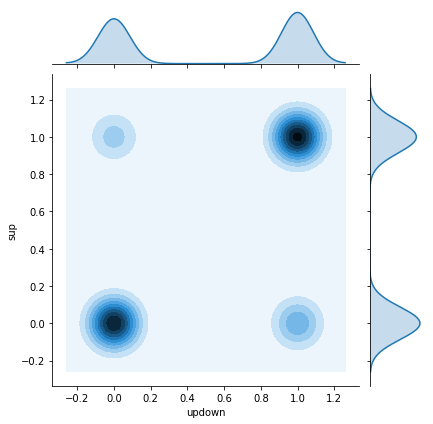

In [69]:
sns.jointplot(dow.updown, dow.sup, kind='kde')

#### Remember!

dowv has same number of row than X, Y vectors, indexes are syncronized

### Lets prepare the engine Torch

In [70]:
import importlib

In [71]:
importlib.reload(torchNN), importlib.reload(torchCV), importlib.reload(torchUtil)

(<module 'algos.nn.torchNN' from '/home/andre/Projects/stocks/algos/nn/torchNN.py'>,
 <module 'algos.nn.torchCV' from '/home/andre/Projects/stocks/algos/nn/torchCV.py'>,
 <module 'algos.nn.torchUtil' from '/home/andre/Projects/stocks/algos/nn/torchUtil.py'>)

In [72]:
device = torchNN.getDevice()

In [73]:
device

device(type='cuda')

In [74]:
torchNN.setSeed(device, 25640) # reproducible

Train in ~ **2 month** and test on the subsequent **0.1 months**

training/valiation ratio of 90%

In [75]:
X, Y = torchUtil.binaryTensors(X, Y, device=device)

In [76]:
ntrain= 22*12*5*4
kfold = torchCV.sKFold(X, foldsize=ntrain, ratio=0.9)
nsplits = kfold.GetnSplits()
ntrain, ntest, npred = kfold.ntrain, kfold.ntest, kfold.npred
print('number of folds ', nsplits, 
      ' H2 of training ', ntrain, 
      ' H2 of validation ', ntest,
      ' H2 of prediction ', npred)

number of folds  3275  H2 of training  4751  H2 of validation  528  H2 of prediction  1


Get a random begin on data of those n years

Locally normalize mean = 0 and variance to 1  
Specially for this 25 type of data/training, this should not be done here. 

In [77]:
#Xfold = (Xfold - Xfold.mean())/Xfold.std() # normalize variance=1 mean=0

In [78]:
# tensors
for start, sval, spred, end in kfold.SplitsLastn(1):
    Xt, yt = X[start:sval], Y[start:sval]
    Xs, ys = X[sval:spred], Y[sval:spred]
    # use :end on slicing to avoid using unsqueze
    Xp, yp = X[spred:end], Y[spred:end] # only ONE sample

In [79]:
start, sval, spred, end

(3274, 8025, 8553, 8554)

In [80]:
yp

tensor([0], device='cuda:0')

In [81]:
print('unbalanced class percentage training ~: % {:.1f}'.format(100*((th.sum(yt).item()/(len(yt))-0.5))))
print('unbalanced class percentage validation~: % {:.1f}'.format(100*((th.sum(ys).item()/len(ys))-0.5)))

unbalanced class percentage training ~: % -2.2
unbalanced class percentage validation~: % -2.7


In [84]:
classifier = torchNN.BinaryNN(input_dim=X.shape[1], nneurons=[256, 256, 128, 32],
                              dropout=0.55, learn=8e-3, patience=100, device=device)

In [85]:
classifier.fit(Xt, yt, Xs, ys, epochs=8, batch=128, iscore=0.5, gma=0.99, learn=1e-3, verbose=True);

iteration : 18     train loss: 0.6877983 valid acc: 0.5265152 valid loss :0.6885294 learn r.: 0.0010000
iteration : 37     train loss: 0.6698688 valid acc: 0.5265152 valid loss :0.6739526 learn r.: 0.0009900
iteration : 56     train loss: 0.6214813 valid acc: 0.7121212 valid loss :0.6349139 learn r.: 0.0009801
iteration : 75     train loss: 0.5607595 valid acc: 0.7291667 valid loss :0.5828850 learn r.: 0.0009703
iteration : 94     train loss: 0.5494856 valid acc: 0.7234848 valid loss :0.5762445 learn r.: 0.0009606
iteration : 113    train loss: 0.5418546 valid acc: 0.7272727 valid loss :0.5738308 learn r.: 0.0009510
iteration : 132    train loss: 0.5396906 valid acc: 0.7196970 valid loss :0.5771824 learn r.: 0.0009415
iteration : 151    train loss: 0.5365341 valid acc: 0.7159091 valid loss :0.5767767 learn r.: 0.0009321
iteration : 170    train loss: 0.5322000 valid acc: 0.7272727 valid loss :0.5744137 learn r.: 0.0009227
iteration : 189    train loss: 0.5302958 valid acc: 0.7348485 va

In [113]:
for i in range(2):
    classifier.fineTune(Xs, ys, batch=128)

[################################################################################] 5/5
[################################################################################] 5/5


In [114]:
dowv.tail(2)

,Open,High,Low,Close,Volume,sup,updown
2019-02-07,-0.031643,-0.034670,-0.036917,-0.035616,-0.267275,0,0
2019-02-08,-0.040824,-0.043212,-0.041926,-0.038428,-0.441898,1,0


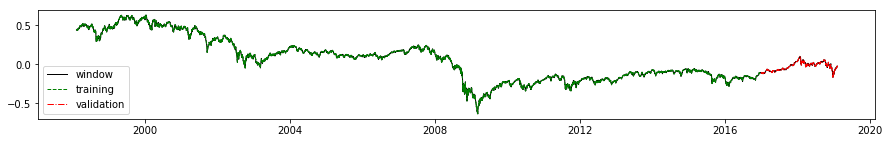

In [115]:
plt.figure(figsize=(15,2))
plt.plot(dowv.iloc[start:end].Close, 'k-', lw=1, label='window')
plt.plot(dowv.iloc[start:sval].Close, 'g--', label='training', lw=1)
plt.plot(dowv.iloc[sval:end].Close, 'r-.', label='validation', lw=1)
plt.legend()

In [116]:
classifier.prog.shape

torch.Size([51, 3])

Using a cut-off on model probability if not certain why should I trust?!  
Try to correct the cases where there is no up or down, just laterall variation or anything else with not that certainty

0.7 or 70% at least

In [117]:
classifier.score(Xs, ys)

0.7746212184429169

In [118]:
params = {'cutoff':0.51}

In [119]:
classifier.score(Xs, ys, **params)

data above probability cutoff: 1.00


0.7756654024124146

To think about...

That above indicates that validation must have a weight.   
Those samples that are more recent should receive a higher 'weight' somehow.

We cannot train too much on a validation set that is too far behind on time. 

Also there are breaking points when the market totally loose correlation from the past.  
For example above near end november.

### Best 54.4% on validation

- `gamma`  should not be too low (~0.9) otherwise we have overfitting on training set 
- a low `gamma` value makes it go to a local minima that is the validation minima

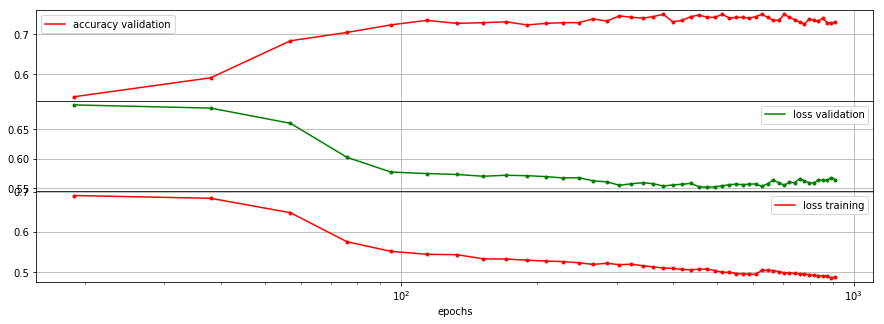

In [120]:
classifier.viewResults()

###  Results

Let's see latest forecasts.

In [122]:
dowv.tail(3)

,Open,High,Low,Close,Volume,sup,updown
2019-02-06,-0.027168,-0.029455,-0.024235,-0.026585,-0.443669,0,0
2019-02-07,-0.031643,-0.034670,-0.036917,-0.035616,-0.267275,0,0
2019-02-08,-0.040824,-0.043212,-0.041926,-0.038428,-0.441898,1,0


### last 22 days / 22 * 2H hours

In [123]:
pdays=22
cutoff=0.4

In [124]:
classifier.score(Xs[-pdays:], ys[-pdays:], cutoff)

data above probability cutoff: 1.00


0.5

### last 10 days / 10 * 2H hours

In [125]:
pdays=10
cutoff=0.5

In [126]:
classifier.score(Xs[-pdays:], ys[-pdays:], cutoff)

data above probability cutoff: 1.00


0.5

## Today

In [127]:
classifier.predict(th.tensor(Xfuture, dtype=th.float, device=device).unsqueeze(dim=0))

(tensor([[0.5381, 0.4619]], device='cuda:0'), tensor([0], device='cuda:0'))

### Cross validation Sequential Folds 

In [128]:
importlib.reload(torchCV)

<module 'algos.nn.torchCV' from '/home/andre/Projects/stocks/algos/nn/torchCV.py'>

In [129]:
# stand-by dont need this now, better use probabilyties before and test
# to find the best cut-off
# accuracy_clip = lambda m, x, y : torchCV.accuracy(m, x, y, cutoff=0.65)

In [130]:
classifier = torchNN.BinaryNN(input_dim=X.shape[1], nneurons=[256, 256, 256, 32],
                              dropout=0.55, learn=1e-3, patience=10, device=device)
params = {'epochs':9, 'batch':128, 'iscore':0.5, 'gma':0.92, 'verbose':False}

#### Run 100 cross-validations on the last n folds

- save predictions as well its probabilities
- pass params using dictionary for 'fit' method

In [131]:
ntrain

4751

In [132]:
params['batch']

128

In [133]:
# torchCV.sCrossValidate(X, Y, classifier, foldsize=ntrain, cv=3, 
#                        fit_params=params, scores=[accuracy_clip], predict=True)
results = torchCV.sCrossValidate(X, Y, classifier, ratio=0.97, foldsize=ntrain, cv=100, fine=2,
                       fit_params=params, predict=True)

[################################################################################] 324/324
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 324/324
[################################################################################] 2/2
[################################################################################] 2/2
early stopped: no progress on validation########################################.] 323/324
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 324/324
[################################################################################] 2/2
[##########################

[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 324/324
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 324/324
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 324/324
[################################################################################] 2/2
[################################################################################] 2/2
[##############################

In [134]:
len(results)

100

In [135]:
metrics = pd.DataFrame(results, columns=['idx', 'trainac', 'validac', 'accpred', 'predb0', 'predb1', 'y' ])

### Need to run cross-validation again 



In [136]:
metrics.head()

,idx,trainac,validac,accpred,predb0,predb1,y
0,8553.0,0.773822,0.727273,1.0,0.515152,0.484848,0.0
1,8552.0,0.785110,0.727273,0.0,0.494419,0.505581,0.0
2,8551.0,0.764923,0.734266,0.0,0.433459,0.566541,0.0
3,8550.0,0.772954,0.727273,0.0,0.679305,0.320695,1.0
4,8549.0,0.782505,0.713287,0.0,0.578751,0.421249,1.0


In [137]:
metrics.idx = metrics.idx.values.astype(int)
metrics.y = metrics.y.values.astype(int)

#### What is the best cut-off

Better do interactvly cutting and calculating the percentage... of data  
should also vary at the same time the model score to see where is the best  
balance between data-percentage and accuracy. 

In [138]:
metrics['probmax'] = metrics.apply(lambda x:  max(x.predb0, x.predb1), axis=1)

/home/andre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


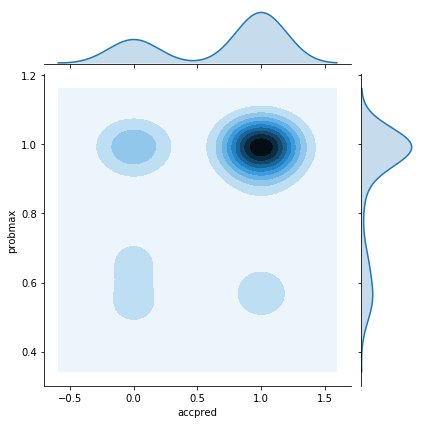

In [139]:
sns.jointplot(metrics.accpred, metrics.probmax, kind='kde')

### Jointplot above suggests 0.8 of cut-off

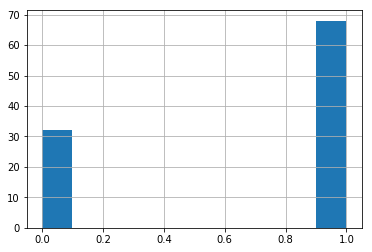

In [140]:
metrics.accpred.hist()

In [141]:
np.mean(metrics.accpred)

0.68

In [142]:
import talib as ta

### Average Accuracy by day

[0.   0.25 0.5  0.75 1.  ]


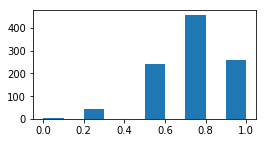

In [245]:
metrics['davpredac'] = ta.SMA(metrics.accpred.values, 4)
plt.figure(figsize=(4,2))
plt.hist(metrics.davpredac.dropna());
print(np.percentile(metrics.davpredac.dropna().values, (0, 1, 10, 50, 90)))
# davpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 4)
# plt.figure(figsize=(4,2))
# plt.hist(davpredac_c.dropna());
# print(np.percentile(davpredac_c.dropna(), (0, 1, 10, 50, 90)))

### Average Accuracy by week

[0.5  0.55 0.6  0.75 0.85]


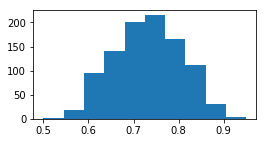

In [246]:
metrics['wavpredac'] = ta.SMA(metrics.accpred.values, 20)
plt.figure(figsize=(4,2))
plt.hist(metrics.wavpredac.dropna());
print(np.percentile(metrics.wavpredac.dropna().values, (0, 1, 10, 50, 90)))
# wavpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 20)
# plt.figure(figsize=(4,2))
# plt.hist(wavpredac_c.dropna());
# print(np.percentile(wavpredac_c.dropna(), (0, 1, 10, 50, 90)))

In [247]:
metrics['modelscore'] = np.sqrt(metrics.trainac*metrics.validac)

/home/andre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


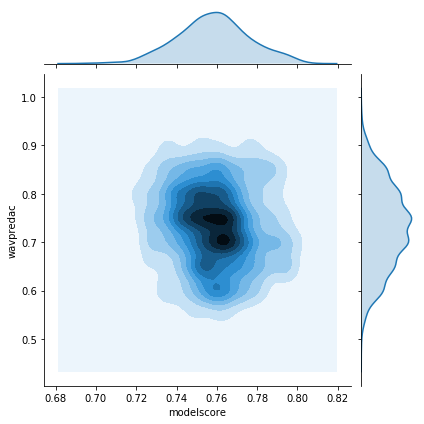

In [248]:
sns.jointplot(metrics.modelscore, metrics.wavpredac, kind='kde')

In [249]:
print(np.percentile(metrics.wavpredac[ metrics.modelscore > 0.525 ].dropna(), (0, 1, 10, 50, 90)))

[0.5  0.55 0.6  0.75 0.85]


In [250]:
len(metrics.wavpredac[ metrics.modelscore > 0.78 ].dropna())/len(metrics.wavpredac.dropna())

0.1120162932790224

In [251]:
metrics[-10:]

,idx,trainac,validac,accpred,predb0,predb1,y,probmax,davpredac,wavpredac,modelscore
991,7562,0.765140,0.748252,1.0,0.975076,0.024924,0,0.975076,0.75,0.80,0.756649
992,7561,0.775342,0.790210,1.0,0.016072,0.983928,1,0.983928,0.75,0.85,0.782741
993,7560,0.778381,0.797203,0.0,0.133723,0.866277,0,0.866277,0.50,0.80,0.787736
994,7559,0.779466,0.783217,1.0,0.908716,0.091284,0,0.908716,0.75,0.80,0.781339
995,7558,0.769264,0.790210,1.0,0.997378,0.002622,0,0.997378,0.75,0.85,0.779667
996,7557,0.780551,0.769231,1.0,0.059932,0.940068,1,0.940068,0.75,0.90,0.774870
997,7556,0.778815,0.776224,1.0,0.986574,0.013426,0,0.986574,1.00,0.90,0.777518
998,7555,0.778815,0.797203,1.0,0.037894,0.962106,1,0.962106,1.00,0.90,0.787955
999,7554,0.779683,0.790210,0.0,0.226118,0.773882,0,0.773882,0.75,0.85,0.784929
1000,7553,0.785110,0.797203,1.0,0.977114,0.022886,0,0.977114,0.75,0.85,0.791133


In [252]:
len(results)

1001

In [253]:
def probability(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=20, density=True);
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=20, density=True, cumulative=True);
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

percentiles are  [0.55 0.55 0.6  0.75 0.85]


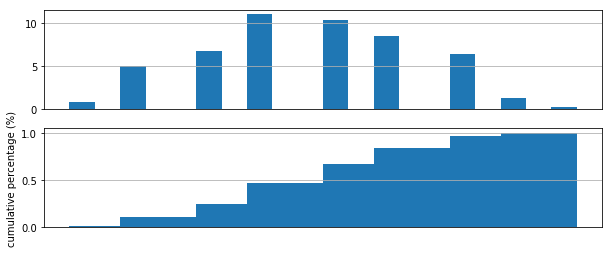

In [254]:
probability(metrics.wavpredac[ metrics.probmax > 0.95 ].dropna());

In [256]:
len(metrics.wavpredac[ metrics.probmax > 0.95 ].dropna())/1001

0.5444555444555444